In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
# set results directory
base_results_dir = Path(cfg.results_dirs['mutation'],
                        'batch_correction')

# which gene to plot
plot_genes = ['TP53', 'KRAS', 'EGFR', 'IDH1', 'SETD2', 'PIK3CA']

# how many features to plot, 1000 or 5000
plot_feats = 1000

In [3]:
def load_single_model(results_dir):
    results_df = pd.DataFrame()
    for results_file in results_dir.iterdir():
        if not results_file.is_file(): continue
        results_filename = str(results_file.stem)
        if results_filename[0] == '.': continue
        if ('classify' not in results_filename or 
            'metrics' not in results_filename): continue
        id_results_df = pd.read_csv(results_file, sep='\t')
        results_df = pd.concat((results_df, id_results_df))
    return results_df
    
def load_all_models(base_results_dir, genes, num_feats):
    models = ['linear', 'nonlinear', 'linear_bc', 'nonlinear_bc']
    results_df = pd.DataFrame()
    for gene in genes:
        for model in models:
            results_dir = Path(base_results_dir,
                               '{}_{}'.format(model, num_feats),
                               'gene',
                               gene)
            try:
                model_results_df = load_single_model(results_dir)
                model_results_df['model'] = model
                model_results_df['num_feats'] = num_feats
            except FileNotFoundError:
                model_results_df = pd.DataFrame()
            results_df = pd.concat((results_df, model_results_df))
    return results_df

In [4]:
results_df = load_all_models(base_results_dir, plot_genes, plot_feats)
print(results_df.shape)
results_df.head()

(1152, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,model,num_feats
0,0.75294,0.72823,TP53,expression,shuffled,42,train,0,linear,1000
1,0.73665,0.70309,TP53,expression,shuffled,42,test,0,linear,1000
2,0.62456,0.57947,TP53,expression,shuffled,42,cv,0,linear,1000
3,0.75221,0.72712,TP53,expression,shuffled,42,train,1,linear,1000
4,0.70829,0.68295,TP53,expression,shuffled,42,test,1,linear,1000


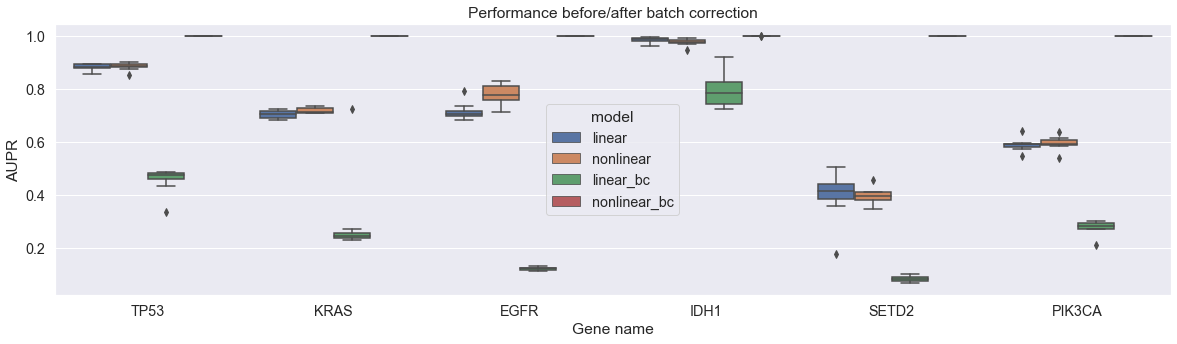

In [5]:
plot_df = results_df[
    (results_df.signal == 'signal') &
    (results_df.data_type == 'test')
]

with sns.plotting_context('notebook', font_scale=1.3):
    sns.set({'figure.figsize': (20, 5)})
    sns.boxplot(data=plot_df, x='identifier', y='aupr', hue='model')
    plt.xlabel('Gene name')
    plt.ylabel('AUPR')
    plt.title('Performance before/after batch correction')

In [6]:
cmp_results_df = pd.DataFrame()
for model in results_df.model.unique():
    cmp_model_results_df = au.compare_control_ind(results_df[results_df.model == model],
                                                  identifier='identifier',
                                                  metric='aupr',
                                                  verbose=True)
    cmp_model_results_df['model'] = model
    cmp_results_df = pd.concat((cmp_results_df, cmp_model_results_df))
cmp_results_df.head()

,identifier,seed,fold,delta_aupr,model
0,EGFR,42,0,0.53390,linear
1,EGFR,42,1,0.50484,linear
2,EGFR,42,2,0.62369,linear
3,EGFR,42,3,0.55159,linear
4,EGFR,1,0,0.51877,linear


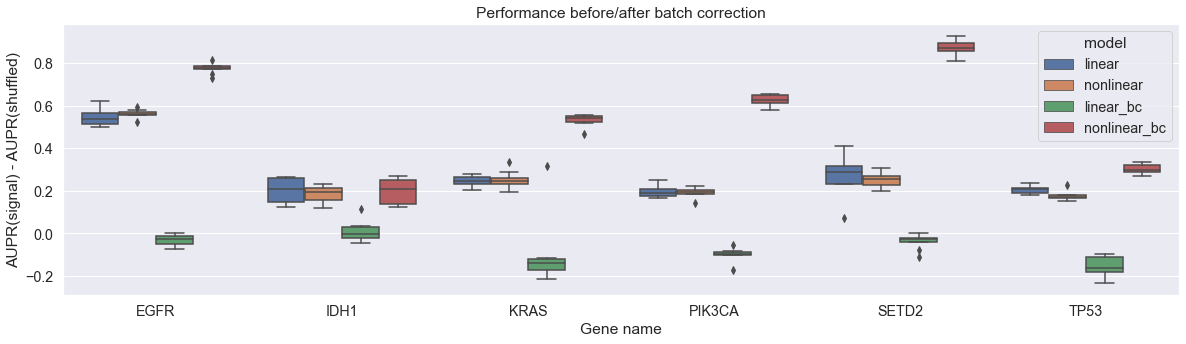

In [7]:
sns.set({'figure.figsize': (20, 5)})

with sns.plotting_context('notebook', font_scale=1.3):
    sns.boxplot(data=cmp_results_df, x='identifier', y='delta_aupr', hue='model')
    plt.xlabel('Gene name')
    plt.ylabel('AUPR(signal) - AUPR(shuffled)')
    plt.title('Performance before/after batch correction')

In [8]:
# look at feature importances/coefficients
base_results_dir = Path(cfg.results_dirs['mutation'],
                        'batch_correction_feats')

gene = 'KRAS'
num_feats = 1000
seed = 42
fold = 0

models = ['linear', 'nonlinear', 'linear_bc', 'nonlinear_bc']
all_coefs_df = pd.DataFrame()
for model in models:
    results_dir = Path(base_results_dir,
                       '{}_{}'.format(model, num_feats),
                       'gene',
                       gene)
    coefs_file = '{}_expression_signal_classify_s{}_coefficients.tsv.gz'.format(
        gene, seed)
    coefs_file = results_dir / coefs_file

    coefs_df = pd.read_csv(coefs_file, sep='\t')
    coefs_df = coefs_df.loc[coefs_df.fold == fold, :].copy()
    coefs_df['model'] = model
    coefs_df['is_covariate'] = ~coefs_df['feature'].str.isdigit()
    all_coefs_df = pd.concat((all_coefs_df, coefs_df))
    
print(all_coefs_df.shape)
print(all_coefs_df.model.unique())
all_coefs_df.head()

(4044, 10)
['linear' 'nonlinear' 'linear_bc' 'nonlinear_bc']


,feature,weight,abs,signal,seed,identifier,training_data,fold,model,is_covariate
0,586,0.18786,0.18786,signal,42,KRAS,expression,0,linear,False
1,1848,0.15430,0.15430,signal,42,KRAS,expression,0,linear,False
2,10575,0.12450,0.12450,signal,42,KRAS,expression,0,linear,False
3,22822,0.12384,0.12384,signal,42,KRAS,expression,0,linear,False
4,10205,-0.11218,0.11218,signal,42,KRAS,expression,0,linear,False


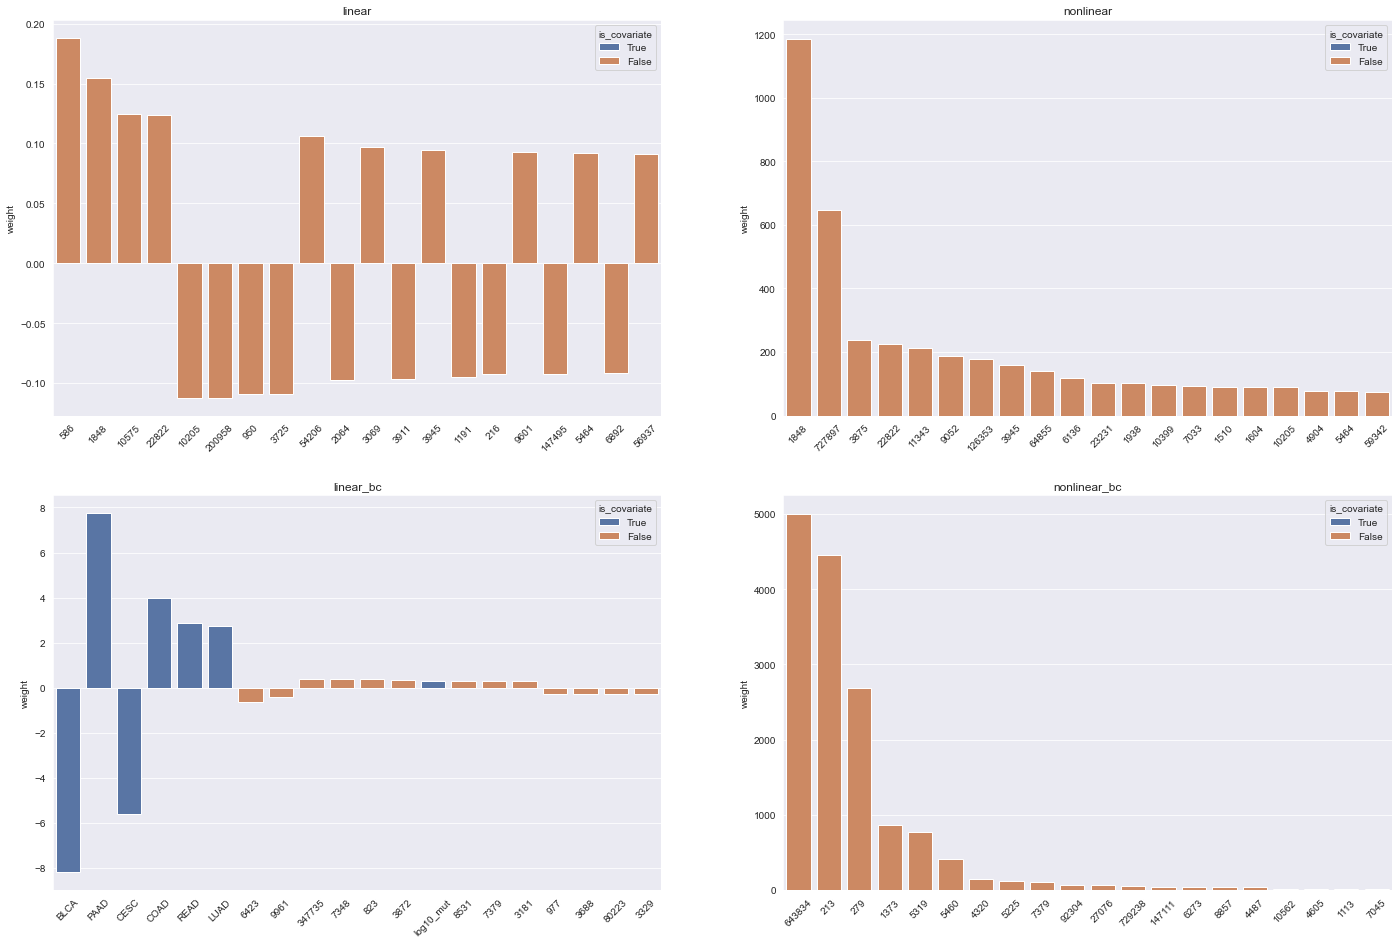

In [9]:
sns.set({'figure.figsize': (24, 16)})
fig, axarr = plt.subplots(2, 2)

for ix, model in enumerate(models):
    ax = axarr[ix // 2, ix % 2]
    plot_df = (all_coefs_df
        [(all_coefs_df.model == model) &
         (all_coefs_df.signal == 'signal')]
        .sort_values(by='abs', ascending=False)
        .iloc[:20, :]
        .reset_index()
    )
    sns.barplot(data=plot_df, x=plot_df.index, y=plot_df.weight,
                dodge=False, hue='is_covariate', hue_order=[True, False],
                ax=ax)
    ax.legend(loc='upper right', title='is_covariate')
    ax.set_title(model)
    ax.set_xticklabels(plot_df.feature)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

In [10]:
model_pairs = [('linear', 'linear_bc'), ('nonlinear', 'nonlinear_bc')]
for pair in model_pairs:
    df1 = (
        all_coefs_df[(all_coefs_df.model == pair[0]) &
                     (all_coefs_df.signal == 'signal') &
                     (all_coefs_df.seed == seed) &
                     (all_coefs_df.fold == fold)]
          .drop(columns=['signal', 'seed', 'fold', 'identifier', 'training_data'])
    )
    df2 = (
        all_coefs_df[(all_coefs_df.model == pair[1]) &
                     (all_coefs_df.signal == 'signal') &
                     (all_coefs_df.seed == seed) &
                     (all_coefs_df.fold == fold)]
          .drop(columns=['signal', 'seed', 'fold', 'identifier', 'training_data'])
          .sort_values(by='abs', ascending=False)
    )
    merged_df = pd.concat((df2, df1))
    top_features = df2.feature[:35]
    merged_df = merged_df[merged_df.feature.isin(top_features)]
print(merged_df.shape)
merged_df.sort_values(by='feature').head()

(70, 5)


,feature,weight,abs,model,is_covariate
29,1056,2.003,2.003,nonlinear_bc,False
258,1056,11.345,11.345,nonlinear,False
16,10562,19.448,19.448,nonlinear_bc,False
63,10562,34.509,34.509,nonlinear,False
247,1113,11.749,11.749,nonlinear,False


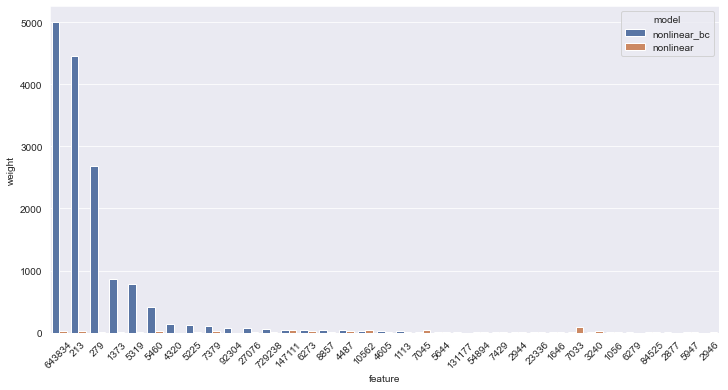

In [11]:
sns.set({'figure.figsize': (12, 6)})
sns.barplot(data=merged_df, x='feature', y='weight', hue='model')
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(45)

In [12]:
# set results directory
cancer_type_base_results_dir = Path(cfg.results_dirs['mutation'],
                                    'bc_cancer_type')

In [13]:
cancer_type_results_df = load_all_models(cancer_type_base_results_dir, plot_genes, plot_feats)
print(cancer_type_results_df.shape)
cancer_type_results_df.head()

(1056, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,model,num_feats
0,0.75294,0.72823,TP53,expression,shuffled,42.0,train,0.0,linear,1000
1,0.73665,0.70309,TP53,expression,shuffled,42.0,test,0.0,linear,1000
2,0.62456,0.57947,TP53,expression,shuffled,42.0,cv,0.0,linear,1000
3,0.75221,0.72712,TP53,expression,shuffled,42.0,train,1.0,linear,1000
4,0.70829,0.68295,TP53,expression,shuffled,42.0,test,1.0,linear,1000


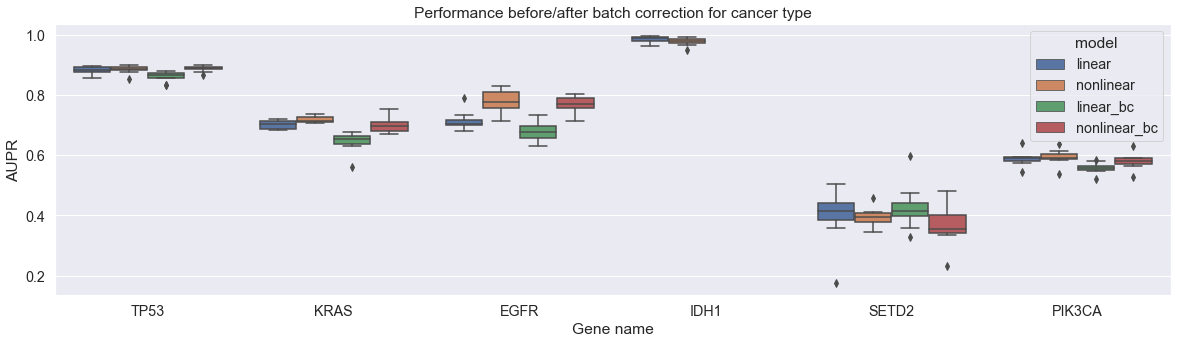

In [14]:
plot_df = cancer_type_results_df[
    (cancer_type_results_df.signal == 'signal') &
    (cancer_type_results_df.data_type == 'test')
]

with sns.plotting_context('notebook', font_scale=1.3):
    sns.set({'figure.figsize': (20, 5)})
    sns.boxplot(data=plot_df, x='identifier', y='aupr', hue='model')
    plt.xlabel('Gene name')
    plt.ylabel('AUPR')
    plt.title('Performance before/after batch correction for cancer type')